In [ ]:
                !pip install -q transformers

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
warnings.filterwarnings('ignore')
# specify GPU
device = torch.device("cuda")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def split_text(text):
    text = text.replace('«', '')
    text = text.replace('»', '')
    text = text.replace('"', '')
    text = text.replace('-', '')

    text = text.replace('т. д.', 'т д')
    text = text.replace('т. п.', 'т п')
    text = text.replace('др.', 'др')

    text = text.replace('...,', ',')
    text = text.replace('?,', ',')
    text = text.replace('!,', ',')
    text = text.replace('.,', ',')
    text = text.replace('.)', ')')
    text = text.replace(';,', ',')

    text = text.replace('....', ';')
    text = text.replace('...', ';')
    text = text.replace('..', ';')

    text = text.replace('!', ';')
    text = text.replace('!!', ';')
    text = text.replace('!!!', ';')
    text = text.replace('?', ';')
    text = text.replace('??', ';')
    text = text.replace('???', ';')
    text = text.replace('!?', ';')
    text = text.replace('?!', ';')
    text = text.replace('.', ';')
    text = text.replace(u'\xa0', u' ')

    return [txt.strip() for txt in text.split(';')]

**Загрузка описания психологических векторов.**

In [ ]:
person_vectors = ("brown", "black", "red", "orange", "yellow", "green", "blue", "purple")
danger_types = ("type1", "type2", "type3", "type4")

In [ ]:
label_map = {'positive': 0, 'negative': 1}
id2label = {0: 'positive', 1: 'negative'}

In [ ]:
train_text = []; train_labels = []

# Загружаем описание личности человека для каждого вектора из книги В.К. Толкачева
for person_vector in person_vectors:
    with open("drive/MyDrive/vectors/" + person_vector + ".txt", encoding="utf8") as rf:
        with open("drive/MyDrive/vectors/" + person_vector + "_neg.txt", encoding="utf8") as rf_:
            sentences_neg = split_text(rf_.read().strip())
            for sentence in split_text(rf.read().strip()):
                if len(sentence) <= 5: continue
                train_text.append(sentence.strip())
                if sentence in sentences_neg:
                    #print(sentence)
                    train_labels.append(1)
                else:
                  train_labels.append(0)

# Загружаем описание личности человека для каждого вектора из книги М.В. Бородянского
for person_vector in person_vectors:
    with open("drive/MyDrive/vectors_/" + person_vector + ".txt", encoding="utf8") as rf:
        with open("drive/MyDrive/vectors_/" + person_vector + "_neg.txt", encoding="utf8") as rf_:
            sentences_neg = split_text(rf_.read().strip())
            for sentence in split_text(rf.read().strip()):
                if len(sentence) <= 5: continue
                train_text.append(sentence.strip())
                if sentence in sentences_neg:
                    #print(sentence)
                    train_labels.append(1)
                else:
                  train_labels.append(0)

# Загружаем описание личности человека для каждого типа из книги Джо Наварро "Опасные личности"
for danger_type in danger_types:
    with open("drive/MyDrive/danger_types/" + danger_type + ".txt", encoding="utf8") as rf:
        for text in rf.readlines():
            for sentence in split_text(text):
              if len(sentence) <= 5: continue
              train_text.append(sentence.strip())
              train_labels.append(1)

train_text = np.array(train_text)
train_labels = np.array(train_labels)

In [ ]:
train_text[:10]

array(['Люди, которых я хотел бы описать, выделяются тем, что в их характере обнаруживается, как правило, присутствие следующих трех черт: они аккуратны, бережливы и упрямы',
       'От себя добавим, что есть в этом характере и четвертая обязательная черта — склонность к садизму, в том числе и в его скрытых, латентных формах',
       'Аккуратность обозначает здесь не только физическую чистоплотность, но также и добросовестность в исполнении иного рода мелких обязательств: на людей аккуратных в этом смысле можно положиться',
       'Эти люди обладают морально нравственной чистоплотностью, иногда просто патологически честны',
       'Такой ребенок может ответить по телефону: Мама сказала, что ее нет дома',
       'Он — классический флегматик (носитель флегматического темперамента), он способен спокойно и рассудительно продумать расходование каждого рубля',
       'При покупке товара в магазине ведет себя крайне нерешительно и выбирает долго, перетрогает и перепробует весь то вар, при это

In [ ]:
val_text = []; val_labels = []

for i in range(2):
    rf = None
    if i == 0:
        with open("drive/MyDrive/val/" + "Дюймовочка.txt", encoding="utf8") as rf:
            for sentence in split_text(rf.read().strip()):
                if len(sentence) <= 5: continue
                val_text.append(sentence.strip())
                val_labels.append(i)
    else:
        with open("drive/MyDrive/val/" + "Потрошитель.txt", encoding="utf8") as rf:
            for sentence in split_text(rf.read().strip()):
                if len(sentence) <= 5: continue
                val_text.append(sentence.strip())
                val_labels.append(i)

val_text = np.array(val_text)
val_labels = np.array(val_labels)

_, val_text, _, val_labels = train_test_split(val_text, val_labels, test_size=0.33, random_state=42)

In [ ]:
np.unique(val_labels)

array([0, 1])

In [ ]:
#train_text, val_text, train_labels, val_labels = train_test_split(df_vectors['description'], df_vectors['vectorId'],
#                                                                    random_state=2018,
#                                                                    test_size=0.2,
#                                                                   stratify=df_vectors['vectorId'])

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("sberbank-ai/ruBert-base")
bert = BertModel.from_pretrained("sberbank-ai/ruBert-base")

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


83


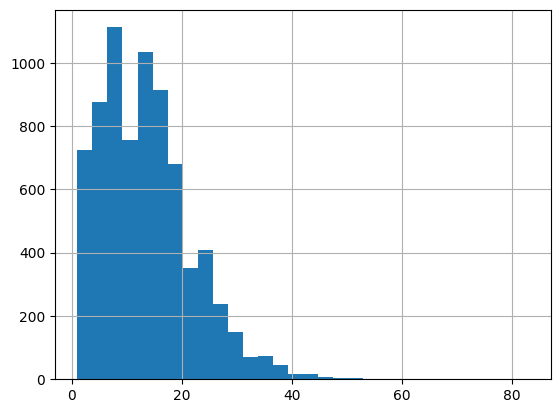

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [ ]:
# tokenize and encode sequences in the training set
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)



In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
print("train_y:",train_y)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
print("val_y:",val_y)


train_y: tensor([0, 1, 0,  ..., 1, 1, 1])
val_y: tensor([1, 1, 1,  ..., 1, 1, 1])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert, num_classes):
        super(BERT_Arch, self).__init__()
        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, num_classes)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)
        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert, 2)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.89650216 1.1305136 ]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss()

# number of training epochs
epochs = 7

In [ ]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]
    total_labels =[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    f1 = f1_score(total_labels, total_preds, average='weighted')
    #returns the loss and predictions
    return avg_loss, f1

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
          #elapsed = format_time(time.time() - t0)

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            total_preds+=list(preds)
            total_labels+=labels.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)

    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, label_map, id2label):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'label_map': label_map,
        'id_map':id2label}
    torch.save(state, filename)

In [ ]:
# set initial loss to infinite
best_train_loss = float('inf')
best_val_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, f1_train = train()

    #evaluate model
    valid_loss, f1_valid = evaluate()

    #save the best model
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        file_name = 'drive/MyDrive/BERT/model_weights_pos.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        file_name = 'drive/MyDrive/BERT/model_weights_pos_val.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')


 Epoch 1 / 7
  Batch   100  of    468.
  Batch   200  of    468.
  Batch   300  of    468.
  Batch   400  of    468.

Evaluating...
  Batch    50  of    153.
  Batch   100  of    153.
  Batch   150  of    153.

Training Loss: 0.523
Validation Loss: 0.788

Training F1: 0.738
Validation F1: 0.687

 Epoch 2 / 7
  Batch   100  of    468.
  Batch   200  of    468.
  Batch   300  of    468.
  Batch   400  of    468.

Evaluating...
  Batch    50  of    153.
  Batch   100  of    153.
  Batch   150  of    153.

Training Loss: 0.460
Validation Loss: 0.826

Training F1: 0.784
Validation F1: 0.661

 Epoch 3 / 7
  Batch   100  of    468.
  Batch   200  of    468.
  Batch   300  of    468.
  Batch   400  of    468.

Evaluating...
  Batch    50  of    153.
  Batch   100  of    153.
  Batch   150  of    153.

Training Loss: 0.450
Validation Loss: 0.809

Training F1: 0.784
Validation F1: 0.682

 Epoch 4 / 7
  Batch   100  of    468.
  Batch   200  of    468.
  Batch   300  of    468.
  Batch   400  of

In [ ]:
path = 'drive/MyDrive/BERT/model_weights_pos_val.pt'

checkpoint = torch.load(path, map_location=device)
model_pos = checkpoint.get("model")

In [ ]:
# tokenize and encode sequences in the test set
test_text = []

with open("drive/MyDrive/val/Потрошитель.txt", encoding="utf8") as rf:
    for sentence in split_text(rf.read().strip()):
        if len(sentence) <= 5: continue
        test_text.append(sentence.strip())

test_text = np.array(test_text)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 250,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [ ]:
idx = 0
count_seq = 500
need_br = False

vectors_pos = [0] * 2

count = 0

while True:
    count += 1
    next_idx = idx + count_seq
    if idx + count_seq >= len(test_seq) - 1:
        next_idx = len(test_seq)
        need_br = True
    #print(idx, next_idx)
    # get predictions for test data
    logits_pos = None

    with torch.no_grad():
        logits_pos = model(test_seq[idx: next_idx].to(device), test_mask[idx: next_idx].to(device))

    probs_pos = (torch.nn.functional.softmax(logits_pos, dim=1)).detach().cpu().numpy()
    for posId, prob in enumerate(np.mean(probs_pos, axis=0).tolist()):
      vectors_pos[posId] += prob

    idx += count_seq
    if need_br: break

vectors_pos = np.array(vectors_pos) / count

In [ ]:
print('positive: {}, negative - {}'.format(vectors_pos[0], vectors_pos[1]))

positive: 0.3401610334714254, negative - 0.6598389426867167
